In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.autograd import Variable
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [19]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv('../data/comple_pre.csv')

In [3]:
df.drop(df.columns[0], axis=1, inplace=True)

In [4]:
# 시퀀스 데이터 생성 함수
def create_sequences(data, targets, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(targets[i + seq_length])
    return np.array(X), np.array(y)

# 학습 및 테스트 데이터셋 설정
train_ds = df.iloc[:55623, :]
test_ds = df.iloc[55623:, :]

train_y = train_ds.iloc[:, 0].values
train_x = train_ds.iloc[:, 1:].values

test_y = test_ds.iloc[:, 0].values
test_x = test_ds.iloc[:, 1:].values

seq_length = 60

# 학습 데이터 시퀀스 생성
train_x, train_y = create_sequences(train_x, train_y, seq_length)

# 테스트 데이터 시퀀스 생성
test_x, test_y = create_sequences(test_x, test_y, seq_length)

# 텐서로 변환
train_x_tensor_final = torch.tensor(train_x, dtype=torch.float32)
train_y_tensor_final = torch.tensor(train_y, dtype=torch.float32).unsqueeze(1)
test_x_tensor_final = torch.tensor(test_x, dtype=torch.float32)
test_y_tensor_final = torch.tensor(test_y, dtype=torch.float32).unsqueeze(1)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(train_x_tensor_final, train_y_tensor_final)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=32,
                        shuffle=True,  
                        drop_last=True)



In [32]:
# LSTM_Jun 모델 정의
class LSTM_Jun(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM_Jun, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.layer_1 = nn.Linear(hidden_size, 256)
        self.layer_2 = nn.Linear(256, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_out = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()  # Activation Func

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn[-1]  # Use the last hidden state
        out = self.relu(hn)  # pre-processing for first layer
        out = self.layer_1(out)  # first layer
        out = self.relu(out)  # activation func relu
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.layer_3(out)
        out = self.relu(out)
        out = self.layer_out(out)  # Output layer
        return out
    

# 파이토치 모델을 사이킷런 인터페이스에 맞게 래핑
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, num_classes=1, input_size=32, hidden_size=16, num_layers=1, seq_length=60, learning_rate=0.001, epochs=10000):
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.model = LSTM_Jun(num_classes, input_size, hidden_size, num_layers, seq_length)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32).view(-1, self.seq_length, self.input_size)
        y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        for epoch in range(self.epochs):
            self.model.train()
            outputs = self.model(X)
            self.optimizer.zero_grad()
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            if epoch % 200 == 0:
                print(f"Epoch: {epoch}, Loss: {loss.item():.5f}")
    
    def predict(self, X):
        self.model.eval()
        X = torch.tensor(X, dtype=torch.float32).view(-1, self.seq_length, self.input_size)
        outputs = self.model(X)
        return outputs.detach().numpy()

# 샘플 데이터 생성
X, y = make_regression(n_samples=1200, n_features=32, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 학습 데이터 시퀀스 생성
train_x, train_y = create_sequences(X_train, y_train, seq_length)

# 테스트 데이터 시퀀스 생성
test_x, test_y = create_sequences(X_test, y_test, seq_length)

# 하이퍼파라미터 튜닝을 위한 파라미터 그리드 설정
param_grid = {
    'hidden_size': [16],
    'num_layers': [1],
    'learning_rate': [0.001],
    'epochs': [1]
}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
clf = GridSearchCV(PyTorchRegressor(input_size=32, seq_length=60), param_grid, cv=3, scoring='neg_mean_squared_error')
clf.fit(train_x, train_y)

# 최적의 파라미터 출력
print("Best parameters found: ", clf.best_params_)

# 테스트 데이터에 대한 예측 및 정확도 평가
y_pred = clf.predict(test_x)
print("Test MSE: ", mean_squared_error(test_y, y_pred))



Epoch: 0, Loss: 32365.39648
Epoch: 0, Loss: 34473.21484
Epoch: 0, Loss: 35083.40234
Epoch: 0, Loss: 33974.15625
Best parameters found:  {'epochs': 1, 'hidden_size': 16, 'learning_rate': 0.001, 'num_layers': 1}
Test MSE:  35229.735123082355


In [33]:
num_epochs = 1
learning_rate = 0.001
input_size = 32
hidden_size = 16
num_layers = 1
num_classes = 1

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
        
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train.view(-1, 1))                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

In [34]:
LSTM_Jun = LSTM_Jun(num_classes, input_size, hidden_size, num_layers, train_x_tensor_final.shape[1])
model, train_hist = train_model(LSTM_Jun, dataloader, num_epochs = num_epochs, lr = learning_rate, verbose = 200, patience = 10)

Epoch: 0000 train loss : 0.1294


In [35]:
LSTM_Jun

LSTM_Jun(
  (lstm): LSTM(32, 16, batch_first=True)
  (layer_1): Linear(in_features=16, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

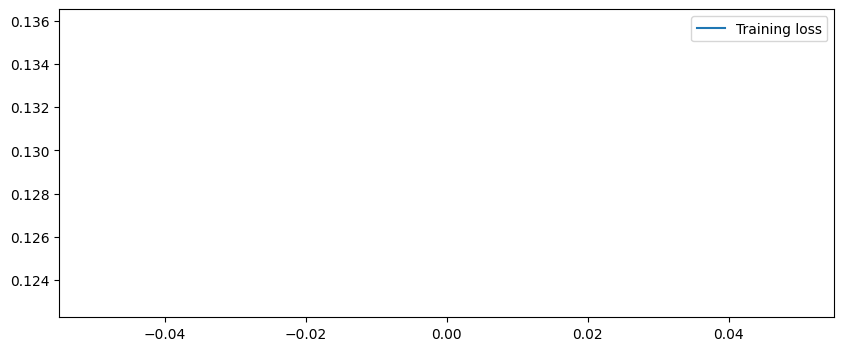

In [36]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [37]:
def inverse_zscore(z, mean, std):
    return z * std + mean

test_predict = LSTM_Jun(test_x_tensor_final) 
predict_data = test_predict.data.detach().cpu().numpy() 
pre_data = inverse_zscore(predict_data, 14.836815923101076, 7.559993882011501) 
real_data = test_y_tensor.data.numpy() 
re_data = inverse_zscore(real_data, 14.836815923101076, 7.559993882011501) 

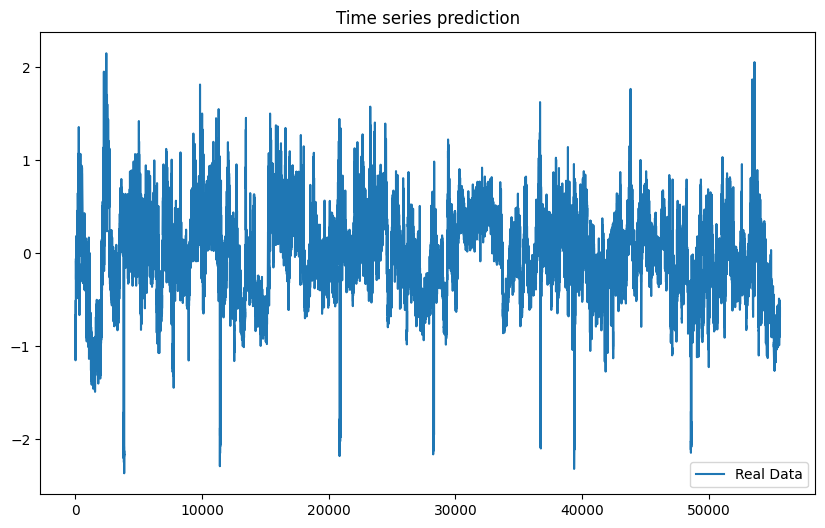

In [9]:
plt.figure(figsize = (10,6)) 
plt.plot(real_data, label = 'Real Data')
plt.plot(predict_data, label = 'predicted data')
plt.title('Time series prediction')
plt.legend()
plt.show()

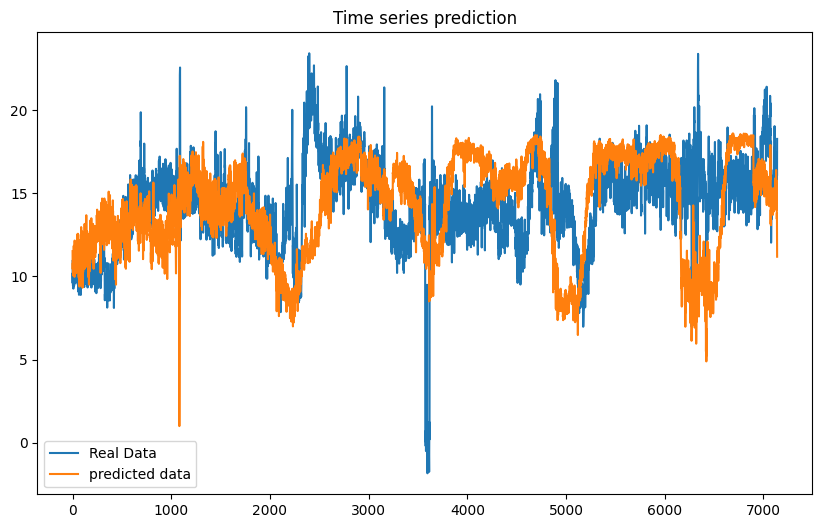

In [39]:
plt.figure(figsize = (10,6)) 
plt.plot(re_data, label = 'Real Data')
plt.plot(pre_data, label = 'predicted data')
plt.title('Time series prediction')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(re_data, pre_data)
print("MSE:", mse)
 
# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
 
# MAE (Mean Absolute Error)
mae = mean_absolute_error(re_data, pre_data)
print("MAE:", mae)
 
# R^2 Score
r2 = r2_score(re_data, pre_data)
print("R^2 Score:", r2)
 
# MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(re_data, pre_data)
print("MAPE:", mape)

MSE: 8.671847
RMSE: 2.9448001
MAE: 2.231572
R^2 Score: -0.20996952056884766
MAPE: 0.7404604
